In [1]:
# ============================================================================
# STEP 1: Setup & Installation
# Run this cell first! (Takes ~2 minutes)
# ============================================================================

print("🚀 Setting up Brainstem Lesion Detection Workshop...")
print("=" * 70)

print("\n📦 Installing packages (this takes ~2 minutes)...")
import sys
!{sys.executable} -m pip install -q nibabel matplotlib numpy pandas scikit-image SimpleITK plotly ipywidgets

print("✅ Packages installed!")

print("\n📚 Importing libraries...")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")
print("\n✅ Ready for next cell!")

🚀 Setting up Brainstem Lesion Detection Workshop...

📦 Installing packages (this takes ~2 minutes)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.3 MB/s eta 0:00:00
✅ Packages installed!

📚 Importing libraries...
✅ Libraries imported!

✅ Ready for next cell!


In [2]:
# ============================================================================
# STEP 2: Create Synthetic Brain MRI Data
# This creates a fake brain with a lesion for teaching
# ============================================================================

print("\n🧠 Creating sample brain MRI data...")

def create_sample_brainstem_mri():
    """Generate synthetic brainstem MRI for demo"""
    size = (128, 128, 80)

    # Create brain shape
    x = np.linspace(-1, 1, size[0])
    y = np.linspace(-1, 1, size[1])
    z = np.linspace(-1, 1, size[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    # Brain ellipsoid
    brain = ((X**2 / 0.8**2 + Y**2 / 0.8**2 + Z**2 / 1.2**2) < 1).astype(float)

    # Add brainstem region (lower middle)
    brainstem_mask = (np.abs(X) < 0.2) & (np.abs(Y) < 0.2) & (Z < -0.3)

    # Create intensity variations
    brain = brain * (0.7 + 0.3 * np.random.rand(*size))
    brain[brainstem_mask] *= 1.2  # Brainstem slightly brighter

    # Add a lesion in left lateral medulla
    lesion_x, lesion_y, lesion_z = 45, 70, 25
    for i in range(-4, 5):
        for j in range(-4, 5):
            for k in range(-3, 4):
                if i**2 + j**2 + k**2 < 16:
                    if (lesion_x+i < size[0] and lesion_y+j < size[1] and
                        lesion_z+k < size[2]):
                        brain[lesion_x+i, lesion_y+j, lesion_z+k] += 0.4

    # Add noise
    brain += np.random.normal(0, 0.05, size)
    brain = np.clip(brain, 0, 1)

    return brain

# Generate sample data
sample_mri = create_sample_brainstem_mri()
print(f"✅ Created sample MRI with shape: {sample_mri.shape}")
print(f"   (This represents a 3D brain scan with a lesion in the left lateral medulla)")


🧠 Creating sample brain MRI data...
✅ Created sample MRI with shape: (128, 128, 80)
   (This represents a 3D brain scan with a lesion in the left lateral medulla)


In [3]:
# ============================================================================
# STEP 3: Create Visualization Tools
# Functions to view MRI slices
# ============================================================================

def quick_view(data, slice_num=None, axis=2, title="MRI Slice"):
    """Fast visualization of MRI slice"""
    if slice_num is None:
        slice_num = data.shape[axis] // 2

    plt.figure(figsize=(8, 8))

    if axis == 0:
        plt.imshow(data[slice_num, :, :].T, cmap='gray', origin='lower')
    elif axis == 1:
        plt.imshow(data[:, slice_num, :].T, cmap='gray', origin='lower')
    else:
        plt.imshow(data[:, :, slice_num].T, cmap='gray', origin='lower')

    plt.title(f"{title} - Slice {slice_num}/{data.shape[axis]}", fontsize=14)
    plt.colorbar(label='Intensity')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Visualization function ready!")
print("\n💡 Try it: quick_view(sample_mri, slice_num=25, axis=2)")

✅ Visualization function ready!

💡 Try it: quick_view(sample_mri, slice_num=25, axis=2)


🖼️  Viewing synthetic MRI...


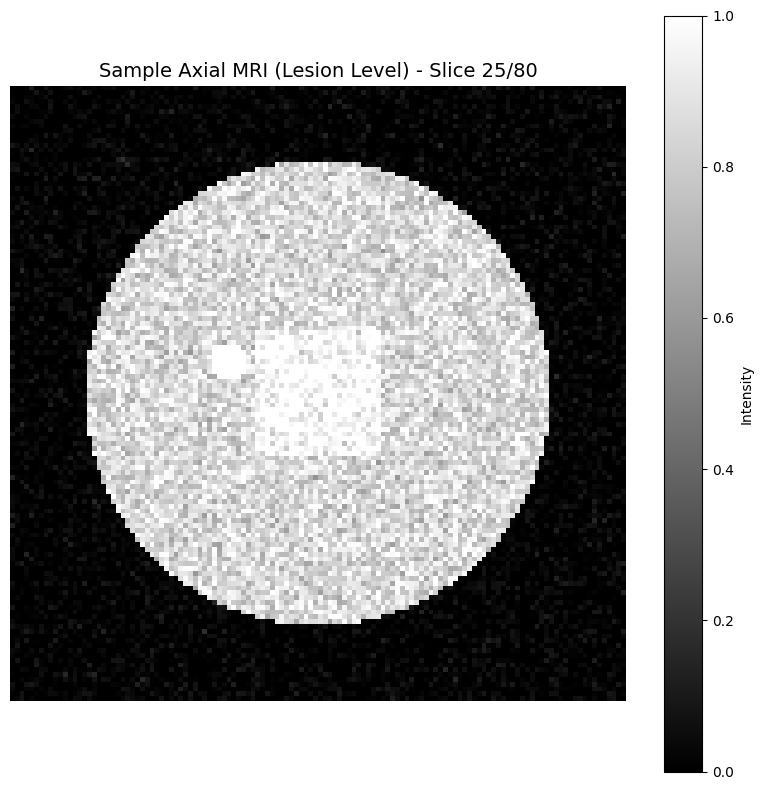


💡 Can you spot the bright lesion?
   Try different slices: quick_view(sample_mri, slice_num=20)


In [4]:
# ============================================================================
# STEP 4: View the Synthetic MRI
# Let's see what our brain looks like!
# ============================================================================

print("🖼️  Viewing synthetic MRI...")
quick_view(sample_mri, slice_num=25, axis=2, title="Sample Axial MRI (Lesion Level)")

print("\n💡 Can you spot the bright lesion?")
print("   Try different slices: quick_view(sample_mri, slice_num=20)")


In [5]:
# ============================================================================
# STEP 5: Interactive MRI Viewer
# Scroll through slices like a radiologist!
# ============================================================================

from ipywidgets import interact, IntSlider, Dropdown

def interactive_mri_viewer(data, orientation='Axial'):
    """Interactive MRI viewer with slider"""

    axis_map = {'Axial': 2, 'Coronal': 1, 'Sagittal': 0}
    axis = axis_map[orientation]

    def show_slice(slice_num):
        quick_view(data, slice_num, axis, f"{orientation} View")

    interact(show_slice,
             slice_num=IntSlider(
                 min=0,
                 max=data.shape[axis]-1,
                 step=1,
                 value=data.shape[axis]//2,
                 description='Slice:'))

print("🎮 Interactive viewer ready!")
print("\n💡 Run this: interactive_mri_viewer(sample_mri, 'Axial')")

# Uncomment to start interactive viewer:
# interactive_mri_viewer(sample_mri, 'Axial')


🎮 Interactive viewer ready!

💡 Run this: interactive_mri_viewer(sample_mri, 'Axial')


In [9]:
# ============================================================================
# STEP 6: Compare with Real MRI Data
# See the difference between synthetic and real scans
# ============================================================================

print("="*70)
print("COMPARING SYNTHETIC vs REAL MRI DATA")
print("="*70)

# Install nilearn
!pip install -q nilearn

from nilearn import datasets
import nibabel as nib

# Get real brain MRI
print("\n📥 Fetching real MRI template...")
mni = datasets.fetch_icbm152_2009()
real_brain = nib.load(mni.t1).get_fdata()

print(f"✅ Real MRI loaded: {real_brain.shape}")
print(f"✅ Our synthetic MRI: {sample_mri.shape}")


COMPARING SYNTHETIC vs REAL MRI DATA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 31.5 MB/s eta 0:00:00

📥 Fetching real MRI template...


[fetch_icbm152_2009] Added README.md to /root/nilearn_data

[fetch_icbm152_2009] Dataset created in /root/nilearn_data/icbm152_2009

[fetch_icbm152_2009] Downloading data from https://osf.io/7pj92/download ...

[fetch_icbm152_2009]  ...done. (2 seconds, 0 min)

[fetch_icbm152_2009] Extracting data from 
/root/nilearn_data/icbm152_2009/6986d62a4af09641f8625dc5757f4796/download...

[fetch_icbm152_2009] .. done.

✅ Real MRI loaded: (197, 233, 189)
✅ Our synthetic MRI: (128, 128, 80)


In [10]:
# ============================================================================
# STEP 7: Interactive Comparison Tool
# Explore synthetic vs real MRI side-by-side
# ============================================================================

from ipywidgets import interact, Dropdown, IntSlider

all_scans = {
    'Synthetic (Teaching Model)': sample_mri,
    'Real Patient MRI': real_brain
}

def compare_scans(scan_type, slice_num):
    """View different scan types"""
    scan = all_scans[scan_type]

    # Adjust slice range for each scan
    max_slice = scan.shape[2] - 1
    actual_slice = min(slice_num, max_slice)

    quick_view(scan, slice_num=actual_slice, axis=2)

    if scan_type == 'Synthetic (Teaching Model)':
        print("📘 This is our clean teaching model - perfect for learning!")
    else:
        print("🏥 This is a real MRI - notice the noise and artifacts!")

interact(compare_scans,
         scan_type=Dropdown(options=list(all_scans.keys())),
         slice_num=IntSlider(min=0, max=130, value=70))

print("\n✅ Now you can explore both synthetic and real brain MRIs!")


interactive(children=(Dropdown(description='scan_type', options=('Synthetic (Teaching Model)', 'Real Patient M…


✅ Now you can explore both synthetic and real brain MRIs!



📚 MRI ORIENTATION GUIDE

When we 'slice' through the brain, we can cut in 3 directions:

1. AXIAL (axis=2): Looking DOWN at the brain
   - Like a helicopter view
   - Best for seeing left vs right structures
   - Standard view in most cases

2. CORONAL (axis=1): Looking at the FACE
   - Front-to-back view
   - Like the patient is facing you
   - Good for seeing brainstem levels

3. SAGITTAL (axis=0): Looking from the SIDE
   - Left/right cut through middle
   - Shows front-to-back structures
   - Good for midline lesions

💡 In a real MRI, we look at all three views to localize lesions!



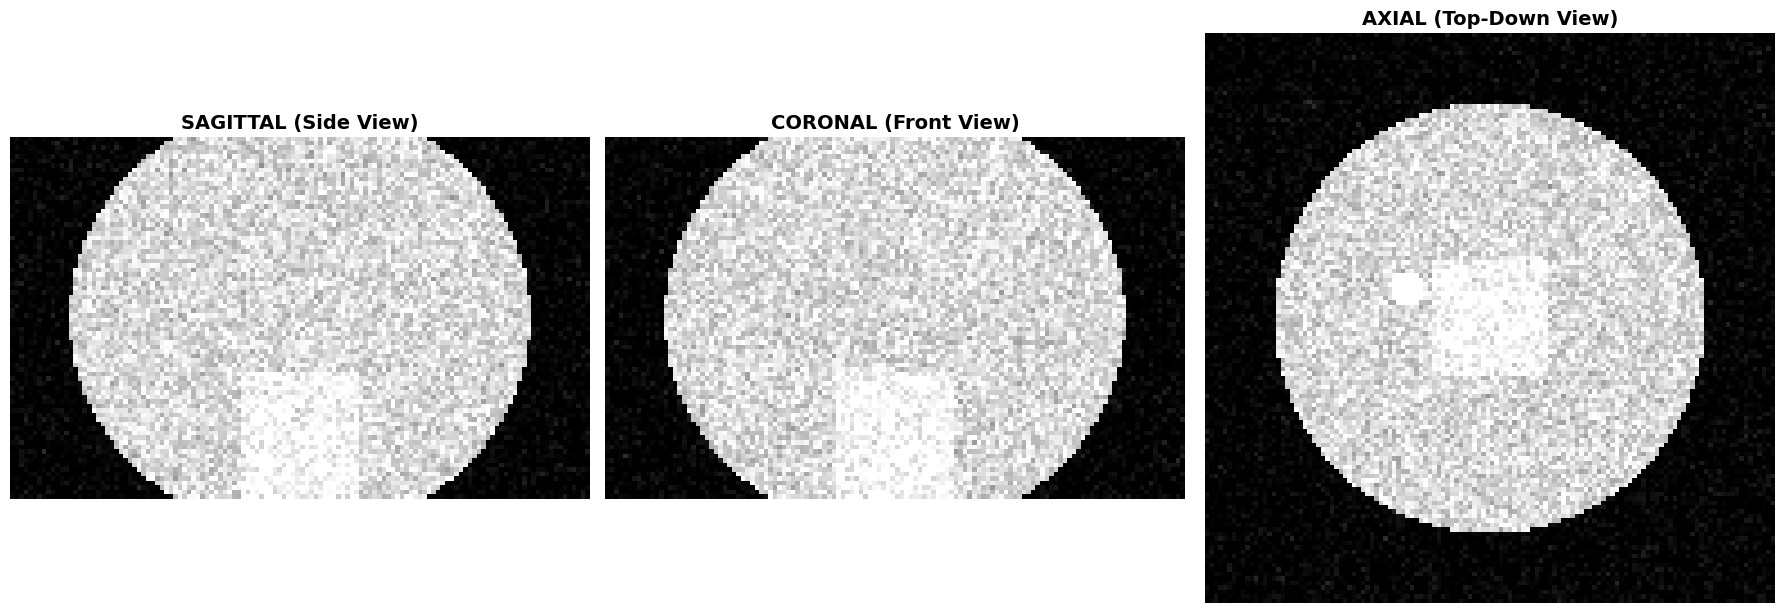

In [11]:
# ============================================================================
# STEP 8: Understanding MRI Slice Orientations
# What are axial, sagittal, coronal views?
# ============================================================================

print("""
📚 MRI ORIENTATION GUIDE

When we 'slice' through the brain, we can cut in 3 directions:

1. AXIAL (axis=2): Looking DOWN at the brain
   - Like a helicopter view
   - Best for seeing left vs right structures
   - Standard view in most cases

2. CORONAL (axis=1): Looking at the FACE
   - Front-to-back view
   - Like the patient is facing you
   - Good for seeing brainstem levels

3. SAGITTAL (axis=0): Looking from the SIDE
   - Left/right cut through middle
   - Shows front-to-back structures
   - Good for midline lesions

💡 In a real MRI, we look at all three views to localize lesions!
""")

# Show all three views
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(sample_mri[64, :, :].T, cmap='gray', origin='lower')
axes[0].set_title('SAGITTAL (Side View)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(sample_mri[:, 64, :].T, cmap='gray', origin='lower')
axes[1].set_title('CORONAL (Front View)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(sample_mri[:, :, 25].T, cmap='gray', origin='lower')
axes[2].set_title('AXIAL (Top-Down View)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


🔍 LESION DETECTION CLUES

Radiologists look for:

1. INTENSITY CHANGES
   - Brighter than surrounding tissue (hyperintense)
   - Darker than surrounding tissue (hypointense)

2. SYMMETRY BREAKING
   - Brain should be mostly symmetric
   - One-sided changes = suspicious

3. SIZE/SHAPE CHANGES
   - Structures that look swollen or compressed
   - Abnormal contours

💡 AI does the SAME THING - just mathematically!
   It learns: "Normal tissue = intensity X, Lesion = intensity Y"



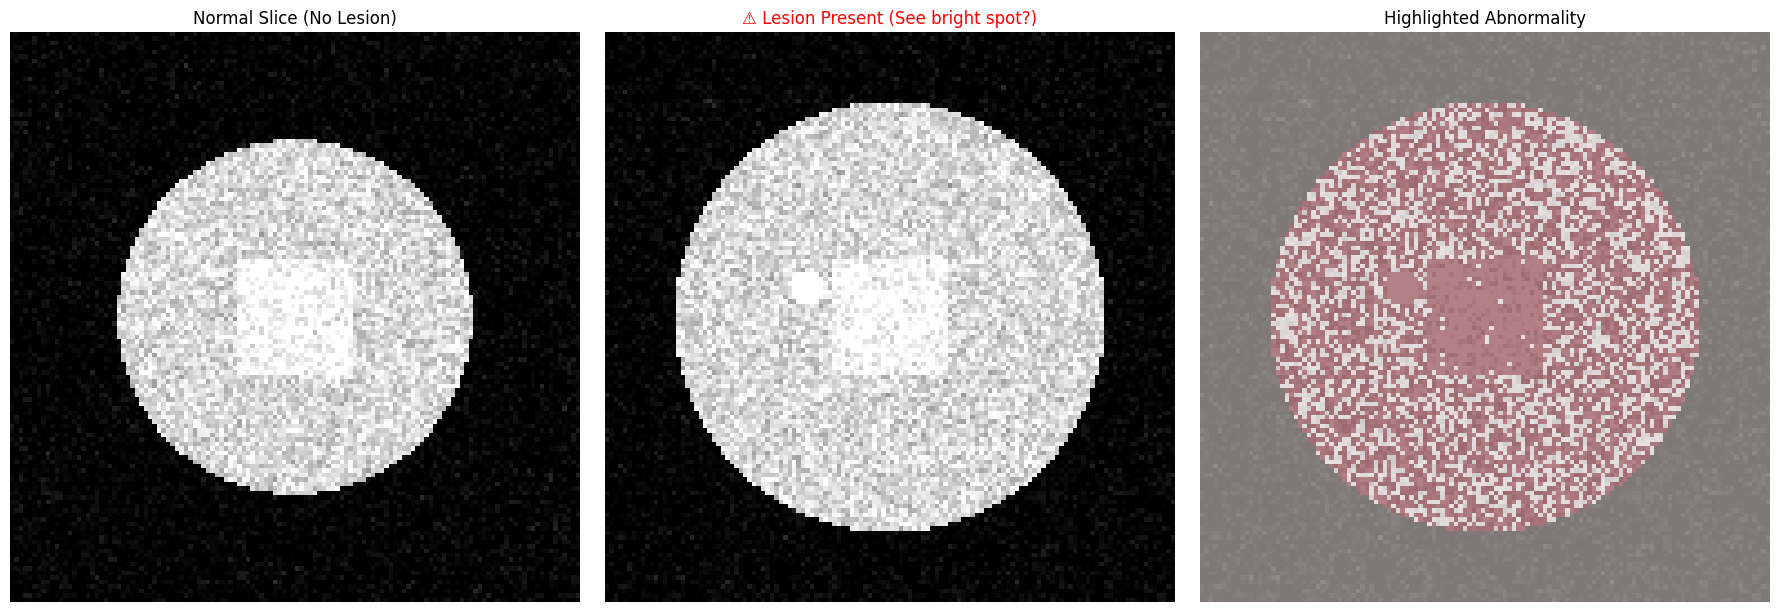


💡 This is similar to what AI does - detect intensity anomalies!


In [12]:
# ============================================================================
# STEP 9: How Do We Spot Lesions?
# ============================================================================

print("""
🔍 LESION DETECTION CLUES

Radiologists look for:

1. INTENSITY CHANGES
   - Brighter than surrounding tissue (hyperintense)
   - Darker than surrounding tissue (hypointense)

2. SYMMETRY BREAKING
   - Brain should be mostly symmetric
   - One-sided changes = suspicious

3. SIZE/SHAPE CHANGES
   - Structures that look swollen or compressed
   - Abnormal contours

💡 AI does the SAME THING - just mathematically!
   It learns: "Normal tissue = intensity X, Lesion = intensity Y"
""")

# Show lesion detection
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normal slice (no lesion)
axes[0].imshow(sample_mri[:, :, 10].T, cmap='gray', origin='lower')
axes[0].set_title('Normal Slice (No Lesion)', fontsize=12)
axes[0].axis('off')

# Lesion slice
axes[1].imshow(sample_mri[:, :, 25].T, cmap='gray', origin='lower')
axes[1].set_title('⚠️ Lesion Present (See bright spot?)', fontsize=12, color='red')
axes[1].axis('off')

# Highlight the lesion
lesion_slice = sample_mri[:, :, 25].copy()
threshold = lesion_slice.mean() + lesion_slice.std()
lesion_mask = lesion_slice > threshold

axes[2].imshow(lesion_slice.T, cmap='gray', origin='lower')
axes[2].imshow(lesion_mask.T, cmap='Reds', alpha=0.5, origin='lower')
axes[2].set_title('Highlighted Abnormality', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 This is similar to what AI does - detect intensity anomalies!")

In [6]:
# ============================================================================
# STEP 10: Brainstem Syndrome Database
# Clinical correlation tool
# ============================================================================

class SimpleSyndromeLocalizer:
    """Quick syndrome lookup tool"""

    def __init__(self):
        self.syndromes = {
            'medial_medulla': {
                'name': 'Medial Medullary Syndrome (Dejerine)',
                'structures': ['Pyramid', 'Medial lemniscus', 'Hypoglossal nucleus (CN XII)'],
                'ipsilateral_signs': ['Tongue deviation toward lesion', 'Tongue weakness'],
                'contralateral_signs': ['Hemiparesis', 'Loss of proprioception/vibration'],
                'mnemonic': 'Medial = Motor pathway damage'
            },
            'lateral_medulla': {
                'name': 'Lateral Medullary Syndrome (Wallenberg)',
                'structures': ['Spinothalamic tract', 'Nucleus ambiguus', 'Vestibular nuclei',
                              'Sympathetic fibers', 'Spinal trigeminal nucleus'],
                'ipsilateral_signs': ['Horner syndrome', 'Ataxia', 'Facial pain/temp loss',
                                     'Dysphagia', 'Hoarseness'],
                'contralateral_signs': ['Body pain/temperature loss'],
                'mnemonic': 'Don\'t Pick A Horse That Can\'t Run - Dysphagia, Pain (face), Ataxia, Horner, Temp loss (body), Cranial nerves'
            },
            'medial_pons': {
                'name': 'Medial Pontine Syndrome',
                'structures': ['Corticospinal tract', 'Medial lemniscus', 'Abducens nucleus (CN VI)', 'MLF'],
                'ipsilateral_signs': ['Lateral gaze palsy (can\'t look toward lesion)', 'Diplopia'],
                'contralateral_signs': ['Hemiparesis', 'Loss of proprioception/vibration'],
                'mnemonic': 'Six is in the mix - CN VI affected'
            },
            'lateral_pons': {
                'name': 'Lateral Pontine Syndrome',
                'structures': ['Middle cerebellar peduncle', 'Facial nucleus (CN VII)',
                              'Spinal trigeminal nucleus'],
                'ipsilateral_signs': ['Facial paralysis', 'Facial sensory loss', 'Ataxia', 'Horner (if sympathetics affected)'],
                'contralateral_signs': ['Body pain/temperature loss'],
                'mnemonic': 'Facial features - CN VII prominent'
            },
            'dorsal_midbrain': {
                'name': 'Dorsal Midbrain Syndrome (Parinaud)',
                'structures': ['Superior colliculi', 'Posterior commissure', 'Periaqueductal gray'],
                'ipsilateral_signs': ['Vertical gaze palsy (can\'t look up)', 'Light-near dissociation',
                                     'Convergence-retraction nystagmus', 'Lid retraction (Collier sign)'],
                'contralateral_signs': ['Usually none - bilateral syndrome'],
                'mnemonic': 'Can\'t look UP in Parinaud - dorsal location'
            },
            'ventral_midbrain': {
                'name': 'Ventral Midbrain Syndrome (Weber)',
                'structures': ['Cerebral peduncle', 'Oculomotor nerve (CN III)'],
                'ipsilateral_signs': ['CN III palsy (ptosis, down-and-out eye, dilated pupil)'],
                'contralateral_signs': ['Hemiparesis'],
                'mnemonic': 'Weber = Weakness + cranial nerve (III)'
            }
        }

    def lookup(self, location):
        """Get syndrome info by location"""
        if location in self.syndromes:
            s = self.syndromes[location]

            print("\n" + "="*70)
            print(f"📍 SYNDROME: {s['name']}")
            print("="*70)

            print(f"\n🧠 Structures Involved:")
            for struct in s['structures']:
                print(f"   • {struct}")

            print(f"\n👉 IPSILATERAL Signs (same side as lesion):")
            for sign in s['ipsilateral_signs']:
                print(f"   • {sign}")

            print(f"\n👈 CONTRALATERAL Signs (opposite side):")
            for sign in s['contralateral_signs']:
                print(f"   • {sign}")

            print(f"\n💡 Memory Aid: {s['mnemonic']}")
            print("="*70 + "\n")
        else:
            print(f"❌ Location '{location}' not found.")
            print(f"   Available: {', '.join(self.syndromes.keys())}")

    def quiz(self):
        """Quick quiz question"""
        import random
        location = random.choice(list(self.syndromes.keys()))
        syndrome = self.syndromes[location]

        print("\n" + "="*70)
        print("🎯 QUIZ TIME!")
        print("="*70)
        print(f"\nA patient presents with:")

        # Show some signs
        shown_signs = []
        if syndrome['ipsilateral_signs']:
            shown_signs.append(f"   • {syndrome['ipsilateral_signs'][0]} (ipsilateral)")
        if syndrome['contralateral_signs']:
            shown_signs.append(f"   • {syndrome['contralateral_signs'][0]} (contralateral)")

        for sign in shown_signs:
            print(sign)

        print(f"\n❓ Question: Where is the lesion?")
        print(f"   Answer: {location.replace('_', ' ').title()}")
        print(f"   Syndrome: {syndrome['name']}")
        print("="*70 + "\n")

        return location

# Initialize syndrome localizer
localizer = SimpleSyndromeLocalizer()

print("✅ Syndrome database loaded!")
print("\n💡 Try: localizer.lookup('lateral_medulla')")
print("💡 Or: localizer.quiz()")

✅ Syndrome database loaded!

💡 Try: localizer.lookup('lateral_medulla')
💡 Or: localizer.quiz()


In [7]:
# ============================================================================
# STEP 11: Look Up a Syndrome
# Find out what our lesion means clinically!
# ============================================================================

# Our synthetic MRI has a lesion in the left lateral medulla
# Let's see what syndrome that causes:

localizer.lookup('lateral_medulla')


📍 SYNDROME: Lateral Medullary Syndrome (Wallenberg)

🧠 Structures Involved:
   • Spinothalamic tract
   • Nucleus ambiguus
   • Vestibular nuclei
   • Sympathetic fibers
   • Spinal trigeminal nucleus

👉 IPSILATERAL Signs (same side as lesion):
   • Horner syndrome
   • Ataxia
   • Facial pain/temp loss
   • Dysphagia
   • Hoarseness

👈 CONTRALATERAL Signs (opposite side):
   • Body pain/temperature loss

💡 Memory Aid: Don't Pick A Horse That Can't Run - Dysphagia, Pain (face), Ataxia, Horner, Temp loss (body), Cranial nerves



In [8]:
# ============================================================================
# STEP 12: Practice Quiz
# Test your brainstem localization skills!
# ============================================================================

localizer.quiz()

# Run this cell multiple times to get different cases!



🎯 QUIZ TIME!

A patient presents with:
   • CN III palsy (ptosis, down-and-out eye, dilated pupil) (ipsilateral)
   • Hemiparesis (contralateral)

❓ Question: Where is the lesion?
   Answer: Ventral Midbrain
   Syndrome: Ventral Midbrain Syndrome (Weber)



'ventral_midbrain'